# 6. Frame Selected Stability

In [4]:
from src import *

In [19]:
from sklearn.linear_model import LinearRegression

D = lambda x,y: ((x-y)**2).sum(axis=1)

def percentile2coord(tup, S):
    """ 
    quick transpose of percentile values to coordinates in matrix
    """
    a = S.index((tup[0],tup[1]))
    b = S.index((tup[2],tup[3]))
    return a,b

In [32]:
sns.set_theme(style='white')

## Description

We look in this section for the stability of frame selected gradients across subjects (individual gradients approach) and also how stable the group gradients are when frame selecting compared to when full is used. 

GOAL: Evaluate differences of individual gradients of selected gradients and movie long gradients + evaluate differences of group gradients of selected timeseries and group gradients of full movies 

## Table of Contents
- [Frame selected (by combined 3FA timecourses) gradients](#comb3fa)
- [Frame selected (by 3FA timecourses) gradients](#3fa)

In [6]:
# In-Tervals percentages
s5 = [(s,s+5) for s in range(0,101,5) if (s+5 <= 100)]
s10 = [(s,s+10) for s in range(0,101,10) if (s+10 <= 100)]
s20 = [(s,s+20) for s in range(0,101,20) if (s+20 <= 100)]
s25 = [(s,s+25) for s in range(0,101,25) if (s+25 <= 100)]
s33 = [(0,33), (33,66), (66,100)]
s50 = [(0,50), (50,100)]

<a class="anchor" id="comb3fa"></a>
## Frame selected (by combined 3FA timecourses) gradients

### Direct Variability / Standard deviations

In [11]:
crosses = ['val-aro', 'val-pow', 'aro-pow']
orig_dfs = []

for cross in crosses:
    fselect_supermovie_grads = load('./resources/fselect_grads/fa_scores_withID/fglobal_cross_grads_supermovie_withID_{}_bin25.pkl'.format(cross))[0]
    orig_df = {'type': [], 'standarddev': []}

    for bounds in tqdm(fselect_supermovie_grads):
        if len(fselect_supermovie_grads[bounds]) == 0:
            orig_df['type'] += [bounds] * 1
            orig_df['standarddev'] += [np.nan]
            continue
        subjects_grad = np.asarray(list(fselect_supermovie_grads[bounds].values()))
        fscore = np.asarray([D(subjects_grad.mean(axis=1)[k], subjects_grad[k]) for k in range(30)])


        orig_df['type'] += [bounds] * len(fscore.std(axis=0))
        orig_df['standarddev'] += list(fscore.std(axis=0))

    orig_dfs.append(pd.DataFrame.from_dict(orig_df))

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

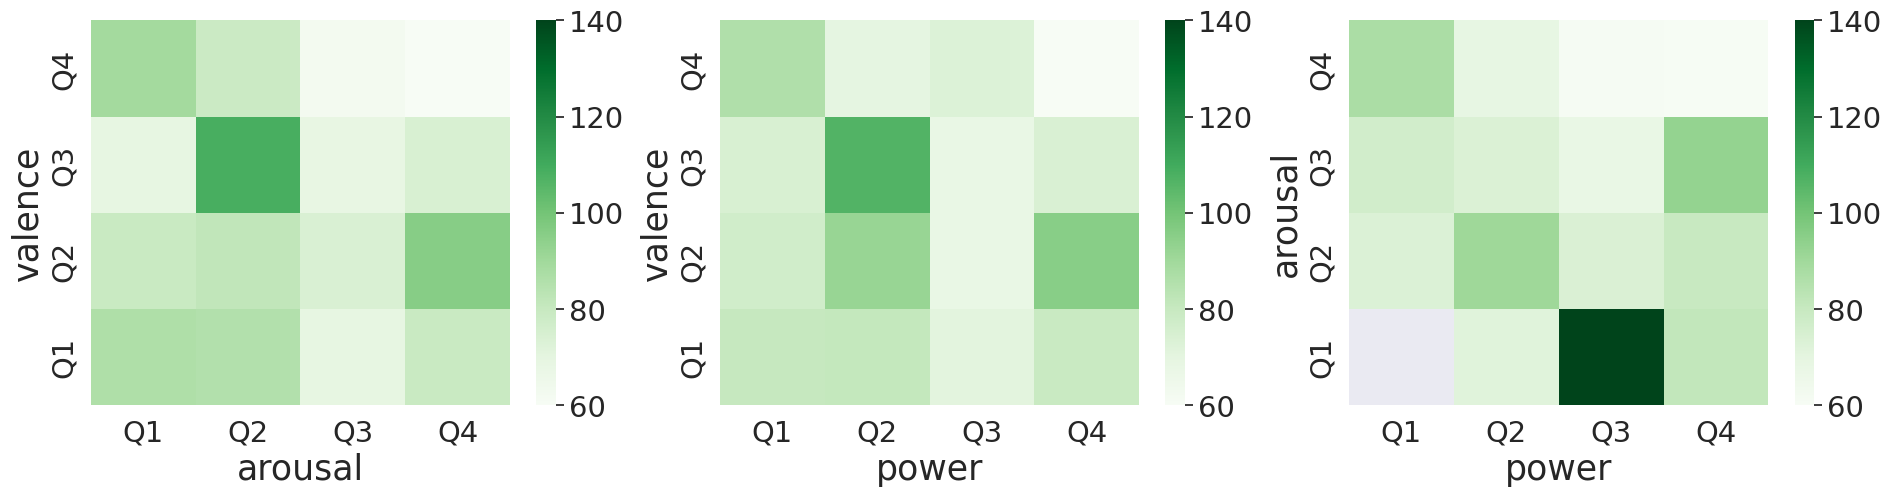

In [14]:
import matplotlib.colors as mcolors

norm = mcolors.Normalize(60, 140)
fig, ax = plt.subplots(1,3, figsize=(23,5))

labels = [('valence', 'arousal'), ('valence','power'), ('arousal','power')]
titlelabels = ['V/A', 'V/P', 'A/P']

tickslabels = ['Q1', 'Q2', 'Q3','Q4']

import seaborn as sns
sns.set(font_scale=1.9)

for k in range(3):
    grid = orig_dfs[k].groupby('type').mean()['standarddev'].values.reshape((4,4))
    sns.heatmap(grid[::-1], annot=False,
               xticklabels=tickslabels, yticklabels=tickslabels[::-1], ax=ax[k], 
                cmap='Greens',fmt='.2f', annot_kws={"size":18}, cbar=True,
               norm=norm)
    
    ax[k].set_xlabel(labels[k][1], fontsize=25)
    ax[k].set_ylabel(labels[k][0], fontsize=25)
#     ax[k].set_title('Standard deviation {}'.format(titlelabels[k]), fontsize=25)

### Correlation of Predictability and standard deviations

In [15]:
base_pred1 = np.asarray(load('./resources/regression_logs/dass_anx_predgrid.pkl'))
base_pred1 = base_pred1.reshape(3,-1)
base_pred2 = np.asarray(load('./resources/regression_logs/big5ope_predgrid.pkl'))
base_pred2 = base_pred2.reshape(3,-1)

#### Omnibus over network and full parcel sets

In [16]:
tmp_index2region = deepcopy(index2region)
tmp_index2region['full'] = np.arange(414)

In [20]:
# per network standard deviations
all_var_grids = []
for tmp in orig_dfs:
    var_grids = []
    for net in tmp_index2region:
        netvar_grid = np.zeros((len(s25),len(s25)))
        for _type in tmp.type.unique():
            x,y = percentile2coord(_type, s25)
            if (tmp[tmp['type']==_type]).standarddev.isnull().any(): continue
            netvar_grid[x,y] = np.nanmean(tmp[tmp['type']==_type].standarddev.values[tmp_index2region[net]])
        var_grids.append(netvar_grid)
    all_var_grids.append(var_grids)
    
all_var_grids = np.asarray(all_var_grids)

# flatten per percentiling
all_var_grids = all_var_grids.reshape(3,9,-1)

In [21]:
null_iter = 250
np.random.seed(99)
base_corr1 = np.zeros(len(tmp_index2region))
null_corr1 = np.zeros((null_iter, len(tmp_index2region)))
for net in range(base_corr1.shape[0]):
    base_corr1[net] = pearson_correlation(base_pred1.flatten(), all_var_grids[:,net].flatten())
    
    # Generate null distrib
    for nidx in range(null_iter):
        shuffle_arr = deepcopy(base_pred1.flatten())
        np.random.shuffle(shuffle_arr)
        null_corr1[nidx][net] = pearson_correlation(shuffle_arr, all_var_grids[:,net].flatten())
        
np.random.seed(99)
base_corr2 = np.zeros(len(tmp_index2region))
null_corr2 = np.zeros((null_iter, len(tmp_index2region)))
for net in range(base_corr2.shape[0]):
    base_corr2[net] = pearson_correlation(base_pred2.flatten(), all_var_grids[:,net].flatten())
    
    # Generate null distrib
    for nidx in range(null_iter):
        shuffle_arr = deepcopy(base_pred2.flatten())
        np.random.shuffle(shuffle_arr)
        null_corr2[nidx][net] = pearson_correlation(shuffle_arr, all_var_grids[:,net].flatten())
        
# cross differences 
np.random.seed(99)
null_p1_corr = np.zeros((null_iter, len(tmp_index2region)))
null_p2_corr = np.zeros((null_iter, len(tmp_index2region)))
n = len(base_pred2.flatten())
for net in range(base_corr2.shape[0]):
    
    # Generate null distrib
    for nidx in range(null_iter):
        # 1. random size of shuffled
        # rsize = np.random.choice(np.arange(n))
        # building shuffling we switch percentiles between the two personality indexes
        # chosen_idx = np.random.choice(np.arange(n), rsize, replace=False)
        
        # 2. fixed size of shuffled
        # building shuffling we switch percentiles between the two personality indexes
        chosen_idx = np.random.choice(np.arange(n), n//2, replace=False)
        
        shuffle_arr1 = []
        shuffle_arr2 = []
        
        for cidx in range(n):
            if cidx in chosen_idx:
                shuffle_arr1.append(base_pred2.flatten()[cidx])
                shuffle_arr2.append(base_pred1.flatten()[cidx])
            else:
                shuffle_arr1.append(base_pred1.flatten()[cidx])
                shuffle_arr2.append(base_pred2.flatten()[cidx])
        
        null_p1_corr[nidx][net] = pearson_correlation(shuffle_arr1, all_var_grids[:,net].flatten())
        null_p2_corr[nidx][net] = pearson_correlation(shuffle_arr2, all_var_grids[:,net].flatten())


In [23]:
varpred_corr_df1 = {'net': [], 'corr': [], 'pval': []}
varpred_corr_df2 = { 'corr': [], 'pval': []}

for nidx, net in enumerate(tmp_index2region):
    # Compute for DASS Anx
    initial_stat1 = base_corr1[nidx]
    nulldistrib1 = null_corr1[:,nidx]
    pval1 = null_score(nulldistrib1, initial_stat1)
    if initial_stat1 >= 0:
        rel1 = 'positive'
    else:
        rel1 = 'negative'
        
    # Compute for BIG5 Ope
    initial_stat2 = base_corr2[nidx]
    nulldistrib2 = null_corr2[:,nidx]
    pval2 = null_score(nulldistrib2, initial_stat2)
    if initial_stat2 >= 0:
        rel2 = 'positive'
    else:
        rel2 = 'negative'
    
    varpred_corr_df1['net'].append(net)
    varpred_corr_df1['corr'].append(initial_stat1)
    varpred_corr_df1['pval'].append(pval1)
    
#     varpred_corr_df2['net'].append(net)
    varpred_corr_df2['corr'].append(initial_stat2)
    varpred_corr_df2['pval'].append(pval2)

# Compute for difference between DASS Anx and BIG5 Ope
diff_var_pred = {'diffcorr': [], 'pval': []}
for net in range(base_corr2.shape[0]):
    nscore = null_score(null_p1_corr[:,net]-null_p2_corr[:,net], base_corr1[net] - base_corr2[net])
    diff_var_pred['diffcorr'].append(base_corr1[net] - base_corr2[net])
    diff_var_pred['pval'].append(nscore)

In [24]:
tmp_df = pd.concat((pd.DataFrame.from_dict(varpred_corr_df1), pd.DataFrame.from_dict(varpred_corr_df2), 
          pd.DataFrame.from_dict(diff_var_pred)), axis=1)


tmp_df.columns = [['','DASS-ANX','DASS-ANX','BIG5-OPE','BIG5-OPE',
                  'Diff-Corr','Diff-Corr'], ['net','corr','pval','corr','pval','diffcorr','pval']]

tmp_df = np.round(tmp_df,3)

In [35]:
# print(tmp_df.to_latex(index=False))

#### Closer look at parcel levels

In [26]:
# per network standard deviations
all_var_grids = []
for tmp in orig_dfs:
    var_grids = []
    for nidx, net in enumerate(tmp_index2region):
        netvar_grid = np.zeros((len(tmp_index2region[net]),len(s25),len(s25)))
        for _type in tmp.type.unique():
            x,y = percentile2coord(_type, s25)
            if (tmp[tmp['type']==_type]).standarddev.isnull().any(): continue
            netvar_grid[:,x,y] = np.nan_to_num(tmp[tmp['type']==_type].standarddev.values[tmp_index2region[net]])

        var_grids.append(netvar_grid)
    all_var_grids.append(var_grids)
    
all_var_grids = np.asarray(all_var_grids)

/tmp/ipykernel_105721/628363490.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  all_var_grids = np.asarray(all_var_grids)


In [27]:
varpred_corr_df1 = {'net': [], 'corr': []}
varpred_corr_df2 = {'net': [], 'corr': []}

for nidx, net in enumerate(tmp_index2region):
    for parcel_idx in range(len(tmp_index2region[net])):
        
        var_array = np.stack([all_var_grids[k,nidx][parcel_idx] for k in range(3)]).reshape(3,-1)
        
        # Compute for DASS Anx
        initial_stat1 = pearson_correlation(base_pred1.flatten(), var_array.flatten())

        # Compute for BIG5 Ope
        initial_stat2 = pearson_correlation(base_pred2.flatten(), var_array.flatten())

        varpred_corr_df1['net'].append(net)
        varpred_corr_df1['corr'].append(initial_stat1)

        varpred_corr_df2['net'].append(net)
        varpred_corr_df2['corr'].append(initial_stat2)
    
varpred_corr_df1 = pd.DataFrame.from_dict(varpred_corr_df1)
varpred_corr_df2 = pd.DataFrame.from_dict(varpred_corr_df2)

Text(0.5, 1.0, 'DASS Anxiety Variability/Predictability Correlation')

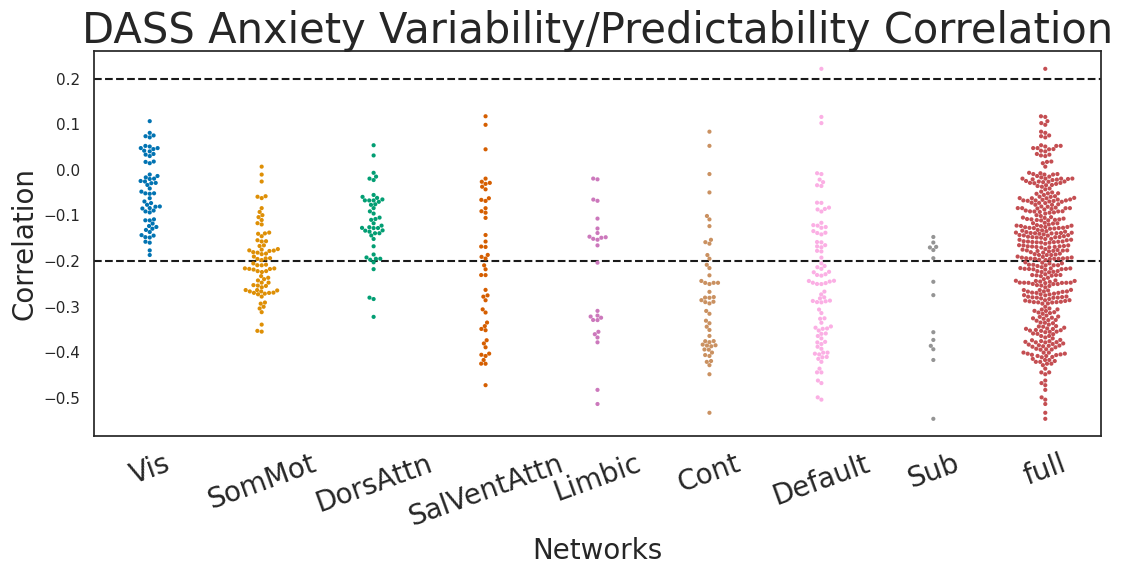

In [31]:
fig, p = plt.subplots(1, figsize=(13,5))
sns.swarmplot(x="net", y="corr", data=varpred_corr_df1,
                  color="r", alpha=1, size=3., dodge=True, 
                  palette=list(sns.color_palette('colorblind', 8)) + ['r'], ax=p)

p.set_xticklabels(tmp_index2region.keys(), rotation=20, fontsize=20)
p.set_ylabel('Correlation', fontsize=20)
p.set_xlabel('Networks', fontsize=20)
p.axhline(y=0.2, linestyle='--', color='k')
p.axhline(y=-0.2, linestyle='--', color='k')
p.set_title('DASS Anxiety Variability/Predictability Correlation', fontsize=30)

Text(0.5, 1.0, 'BIG5 Openness Variability/Predictability Correlation')

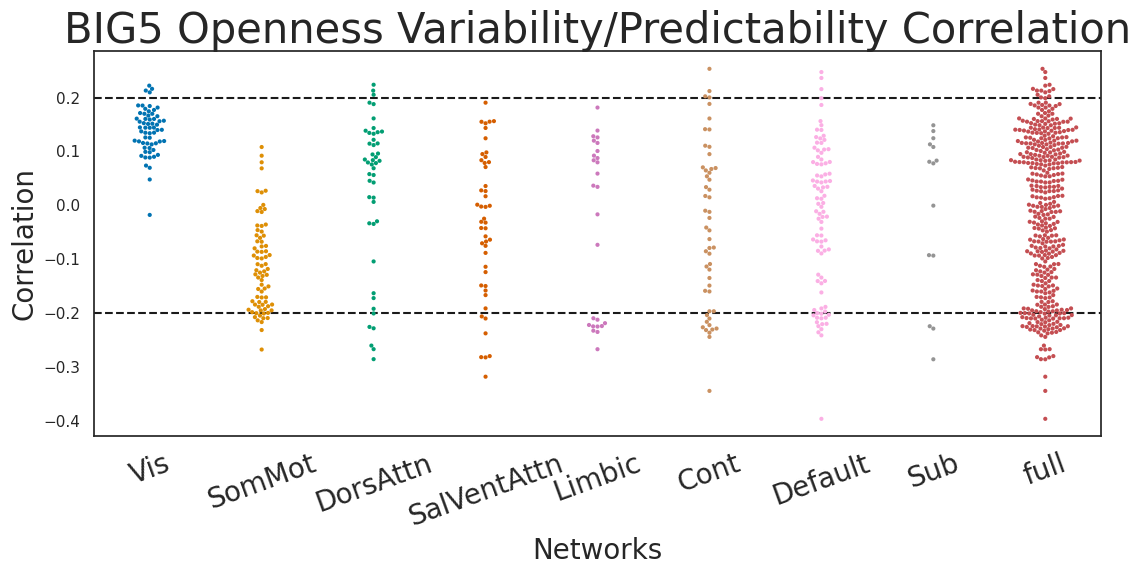

In [33]:
fig, p = plt.subplots(1, figsize=(13,5))
sns.swarmplot(x="net", y="corr", data=varpred_corr_df2,
                  color="r", alpha=1, size=3., dodge=True, 
                  palette=list(sns.color_palette('colorblind', 8)) + ['r'], ax=p)

p.set_xticklabels(tmp_index2region.keys(), rotation=20, fontsize=20)
p.set_ylabel('Correlation', fontsize=20)
p.set_xlabel('Networks', fontsize=20)
p.axhline(y=0.2, linestyle='--', color='k')
p.axhline(y=-0.2, linestyle='--', color='k')
p.set_title('BIG5 Openness Variability/Predictability Correlation', fontsize=30)

<a class="anchor" id="3fa"></a>
## Frame selected (by 3FA timecourses) gradients

In [78]:
# Params
embedding  = "dm" # diffusion map
aff_kernel = "pearson" #affinity matrix kernel
align_meth = "procrustes"
n_iter     = 10 # procrustes align number of iteration
nb_comp    = 3
rs         = 99

threshed_series = load('./resources/threshed_series/fa_global_treshed_series.pkl')

In [6]:
for i in range(3):
    # individual variance variables
    fselect_subjects_gradients = {}
    
    threshed = threshed_series[i]
    for rng in tqdm(threshed.keys()):
        selected_series = threshed[rng]

        # concatenate on different frames across movies
        # basically doing reordering of columns
        tmp = next(iter(selected_series))
        subject_numbers = list(selected_series[tmp].keys())
        subject_tmpseries = {_id:[] for _id in subject_numbers}

        for mname in selected_series:
            if len(selected_series[mname]) == 0: continue
            for _id in subject_numbers:
                subject_tmpseries[_id].append(selected_series[mname][_id])

        subject_series = []
        for _id in subject_numbers:
            subject_series.append(np.concatenate(subject_tmpseries[_id]))

        # if concatenated length not long enough then skip whole process
        if len(subject_series[0]) < 15: 
            fselect_subjects_gradients[rng] = []
            continue

        # Compute individual gradients according to selected frames
        subjects_gradients = []
        for nsub in range(len(subject_numbers)):
            tmp_series = np.asarray(subject_series)[nsub]
            fc_selects = FC(tmp_series)
            g_selects = GradientMaps(n_components=nb_comp, approach=embedding, 
                                kernel=aff_kernel, random_state=rs)
            g_selects.fit(fc_selects)
            subjects_gradients.append(g_selects.gradients_)

        # alignement across all gradients
        select_subjects_gradients,_,s = procrustes_align(np.asarray(subjects_gradients))
        select_subjects_gradients = np.asarray(select_subjects_gradients)
        fselect_subjects_gradients[rng] = select_subjects_gradients

    save('./resources/fselect_grads/fa_scores/fselect_global_subjects_gradientsFA{}.pkl'.format(i),
         fselect_subjects_gradients)

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

In [36]:
fa_stats = {}
# across fa number
for fa_nb in range(3):
    
    fselect_subjects_gradients = load('./resources/fselect_grads/fa_scores/fselect_global_subjects_gradientsFA{}.pkl'.format(fa_nb))
    orig_df = {}
    null_df = {}
    for bounds in tqdm(s5+s10+s20+s25+s33+s50):
        odf = {}
        ndf = {}

        lb,rb = bounds
        ssize = str(rb-lb)
        if ssize == '34': ssize='33' # ssizeck fix

        TMP = load('./resources/null_grad/sample_bins/nulldistrib_random{}.pkl'.format(ssize))

        A = []
        n_iter = 200

        for i in range(n_iter):
            tmp = np.asarray([D(TMP[i][bounds].mean(axis=1)[k],TMP[i][bounds][k]) for k in range(30)])
            A.append(tmp.std(axis=0))

        fscore = np.asarray([D(fselect_subjects_gradients[bounds].mean(axis=1)[k],
                  fselect_subjects_gradients[bounds][k]) for k in range(30)])

        odf['fullnet'] = fscore.std(axis=0)
        ndf['fullnet'] = A

        orig_df[bounds] = odf
        null_df[bounds] = ndf

    orig_df = pd.DataFrame.from_records(orig_df)
    null_df = pd.DataFrame.from_records(null_df)
    
    fa_stats[fa_nb] = (orig_df, null_df)

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

#### Compute slope and locate in null distrib slope

In [37]:
outlier_idx = [357]

fa_null = {}

for fa_nb in range(3):
    orig_df, null_df = fa_stats[fa_nb]
    
    nscores = {B[0][1]-B[0][0]: {} for B in [s25]}

    linear_coef = {B[0][1]-B[0][0]: {} for B in [s25]}
    
    # remove the outlier index
    tmp_index2region = {}
    for net in index2region:
        indexes = index2region[net]
        tmp_index2region[net] = np.array([idx for idx in indexes if idx not in outlier_idx])

    tmp_index2region['full'] = np.array([k for k in range(414) if k not in outlier_idx])

    for B in [s25]:
        for net in tmp_index2region.keys():
            subset = np.arange(len(B))
            # subset = [1,2]

            perdf = np.asarray([orig_df[B].iloc[0][k] for k in range(len(orig_df[B].columns))]).T
            nperdf = np.asarray([null_df[B].iloc[0][k] for k in range(len(null_df[B].columns))])

            # 1. Compute initial statistic
            y_train = np.concatenate([perdf[tmp_index2region[net]][:,i] - perdf[tmp_index2region[net]].mean(axis=1) 
                                      for i in subset])
            X_train = np.concatenate([tmp_index2region[net].shape[0] * [i] for i in range(len(subset))])

            regressor = LinearRegression()
            regressor.fit(X_train.reshape(-1,1), y_train)
            initial_coef = regressor.coef_[0]

            intercept = regressor.intercept_
            linear_coef[B[0][1]-B[0][0]][net] = (initial_coef,intercept)

            # 2. Generate null statistics
            null_distrib = []
            null_intercepts = []
            n_iter = 200

            for k in range(n_iter):
                tmpdf = nperdf[:,k].T
                y_train = np.concatenate([tmpdf[tmp_index2region[net]][:,i] - tmpdf[tmp_index2region[net]].mean(axis=1) 
                                          for i in subset])
                X_train = np.concatenate([tmp_index2region[net].shape[0] * [i] for i in range(len(subset))])
                regressor = LinearRegression()
                regressor.fit(X_train.reshape(-1,1), y_train.reshape(-1,1))
                null_coef = regressor.coef_[0][0]
                null_distrib.append(null_coef)
                null_intercepts.append(regressor.intercept_)

            null_distrib = np.array(null_distrib)
            null_intercepts = np.array(null_intercepts)

            # 3. Compute null score
            nscores[B[0][1]-B[0][0]][net] = null_score(null_distrib, initial_coef)
    
    fa_null[fa_nb] = (nscores, linear_coef)

### Visualize standard deviations for all 3 fa

In [38]:
B = deepcopy(s25)

In [ ]:
def plot_standarddeviations(orig_df, null_df, nscores, linear_coef):
    
    # Note: global variables involved do not move !
    ssize = B[0][1]-B[0][0]
    perdf = np.asarray([orig_df[B].iloc[0][k] for k in range(len(orig_df[B].columns))]).T

    from matplotlib.pyplot import cm

    color = cm.rainbow(np.linspace(0, 1, len(tmp_index2region)))

    # PLOT 1: Entire gradients
    net = 'full'
    fig, ax = plt.subplots(figsize=(15,5))
    region_idx = tmp_index2region[net]

    full_vardf = {'var': [], 'bound': []}
    for ridx in region_idx:
        if ridx in outlier_idx: continue
        # ax.plot(perdf[ridx]-perdf[ridx].mean(), color="c", alpha=0.2, linestyle="--")

        full_vardf['var'] += list(perdf[ridx]-perdf[ridx].mean())
        full_vardf['bound'] += B

    full_vardf = pd.DataFrame.from_dict(full_vardf)
    sns.boxplot(data=full_vardf, x="bound", y="var", ax=ax, palette=sns.color_palette("mako", as_cmap=False))

    a,b = linear_coef[ssize][net]
    flag = nscores[ssize][net] <= 0.05
    # plot trend
    if flag:
        ax.plot(a*np.arange(len(B)) + b,
            color='r',linestyle='--', linewidth=5, 
            label="a={} | pval={}".format(np.round(a,3),nscores[ssize][net]))
    else:
        ax.plot(a*np.arange(len(B)) + b,
            color='k',linestyle='--', linewidth=5,
            label="a={} | pval={}".format(np.round(a,3),nscores[ssize][net]))

    ax.legend(prop={'size':20})
    ax.set_xticklabels([str(b) for b in B], fontsize=25)
    ax.set_xticks(np.arange(0,len(B)), fontsize=25)
    ax.set_xlabel('Bounds', fontsize=25)
    ax.set_ylabel('Variance centered', fontsize=25)

    # PLOT 2: Network-wise gradients
    fig, ax = plt.subplots(len(tmp_index2region)//3,3, figsize=(15,15))
    display_order = list(tmp_index2region.keys())[:-1]
    for idx,net in enumerate(display_order):
        r,c = idx//3, idx%3
        region_idx = tmp_index2region[net]
        ax[r,c].set_title(net, fontsize=17)
        vardf = {'var': [], 'bound': []}
        for ridx in region_idx:
            if ridx in outlier_idx: continue

            # ax[r,c].plot(perdf[ridx]-perdf[ridx].mean(), color=color[idx], alpha=0.3)
            vardf['var'] += list(perdf[ridx]-perdf[ridx].mean())
            vardf['bound'] += B

        vardf = pd.DataFrame.from_dict(vardf)
        sns.boxplot(data=vardf, x="bound", y="var", ax=ax[r,c],palette=sns.color_palette("mako", as_cmap=False))

        a,b = linear_coef[ssize][net]
        flag = nscores[ssize][net] <= 0.05
        # plot trend
        if flag:
            ax[r,c].plot(a*np.arange(len(B)) + b,
                           color='r',linestyle='--', linewidth=5, 
                         label="a={} | pval={}".format(np.round(a,3),nscores[ssize][net]))
        else:
            ax[r,c].plot(a*np.arange(len(B)) + b,
                           color='k',linestyle='--', linewidth=5,
                        label="a={} | pval={}".format(np.round(a,3),nscores[ssize][net]))

        ax[r,c].legend()
        ax[r,c].set_xticklabels([str(b) for b in B])
        ax[r,c].set_xticks(np.arange(0,len(B)))
        ax[r,c].set_xlabel('Bounds')
        ax[r,c].set_ylabel('Variance centered')

#### 1. Valence

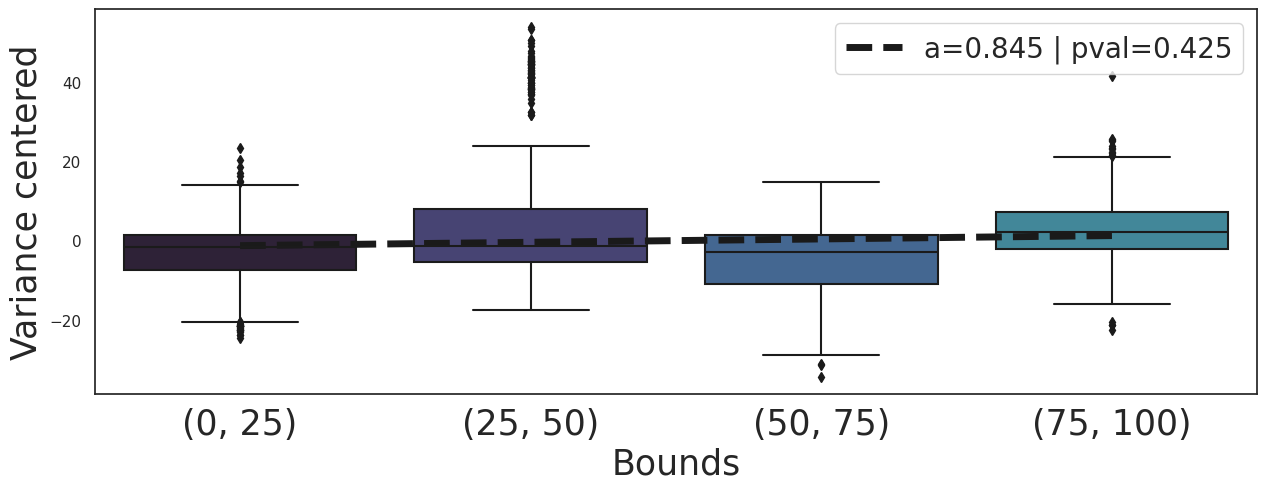

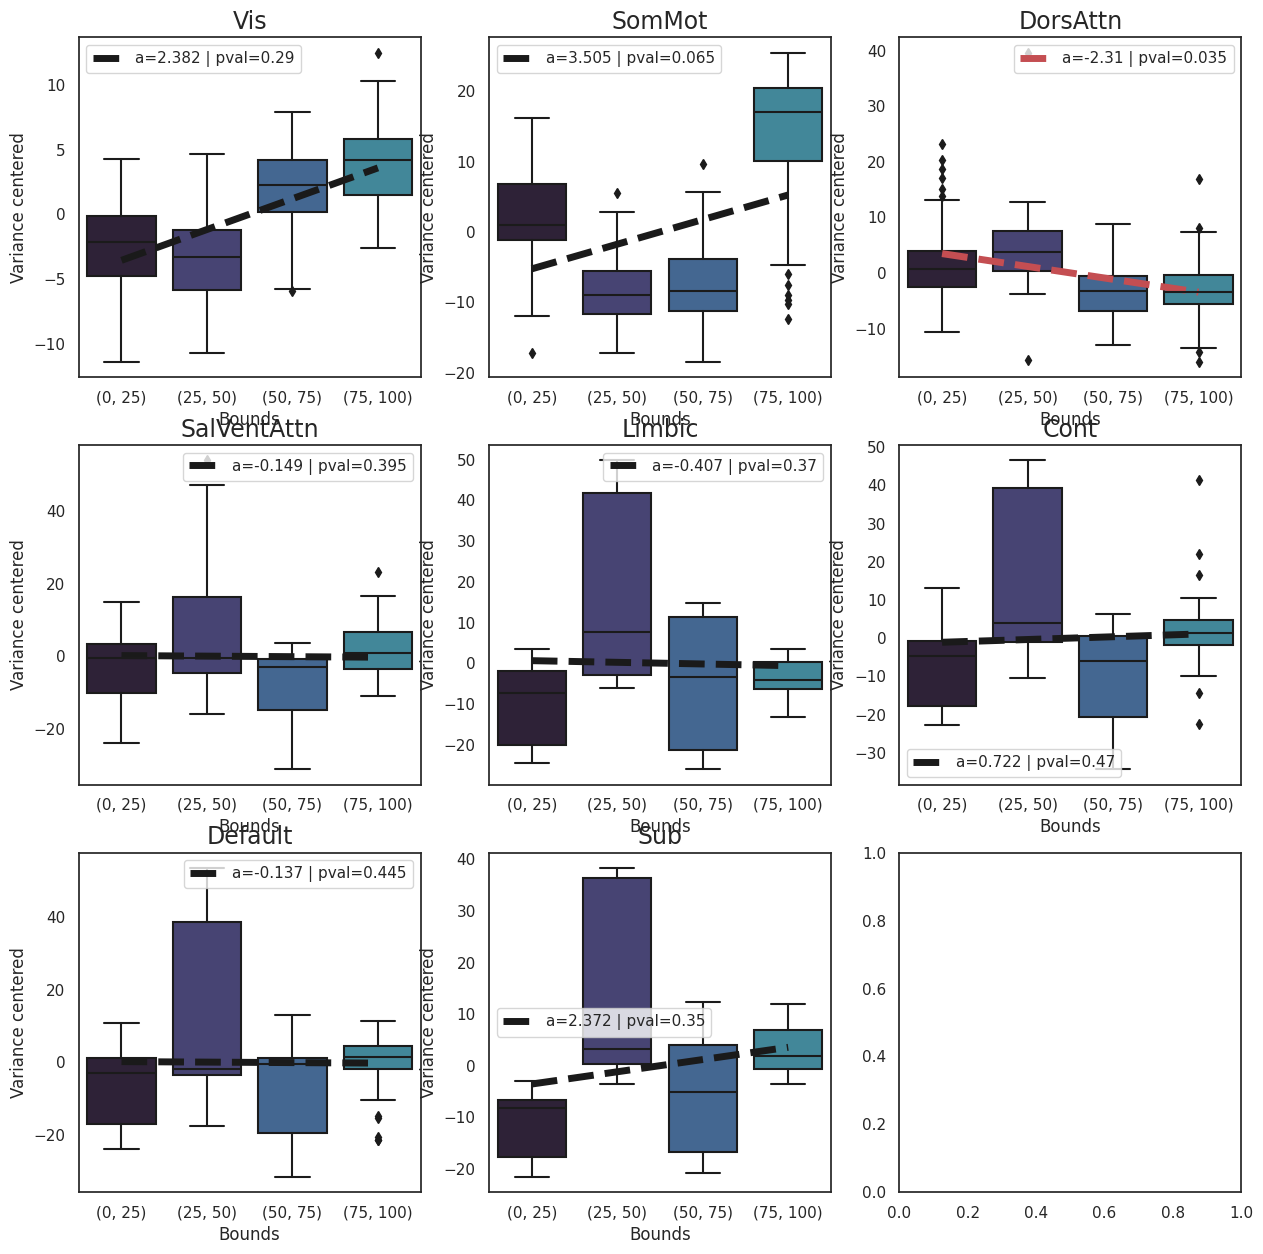

In [40]:
orig_df, null_df = fa_stats[0] # first factor
nscores, linear_coef = fa_null[0]

plot_standarddeviations(orig_df, null_df, nscores, linear_coef)

#### 2. Arousal

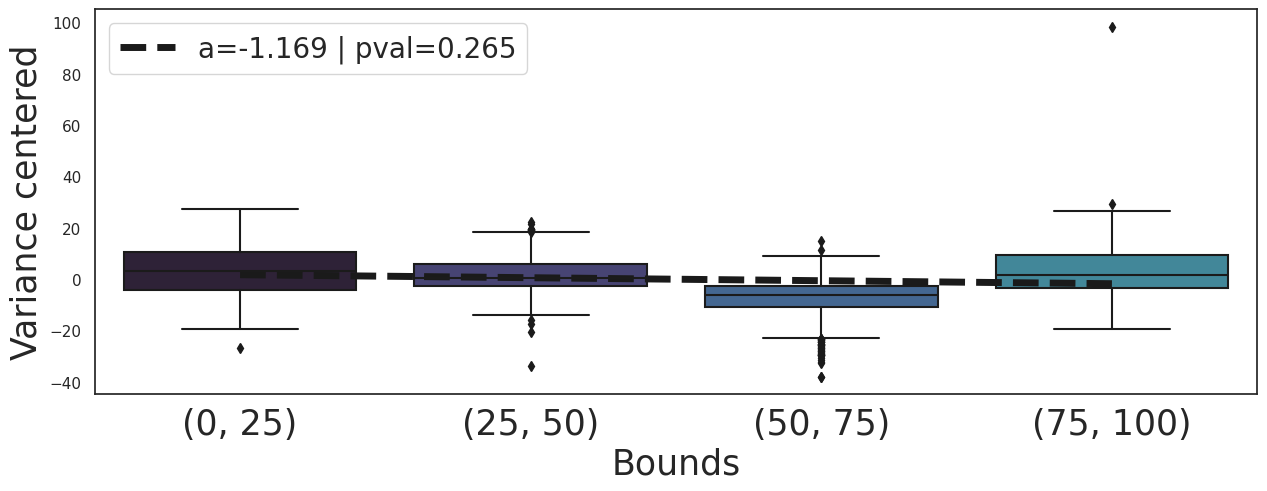

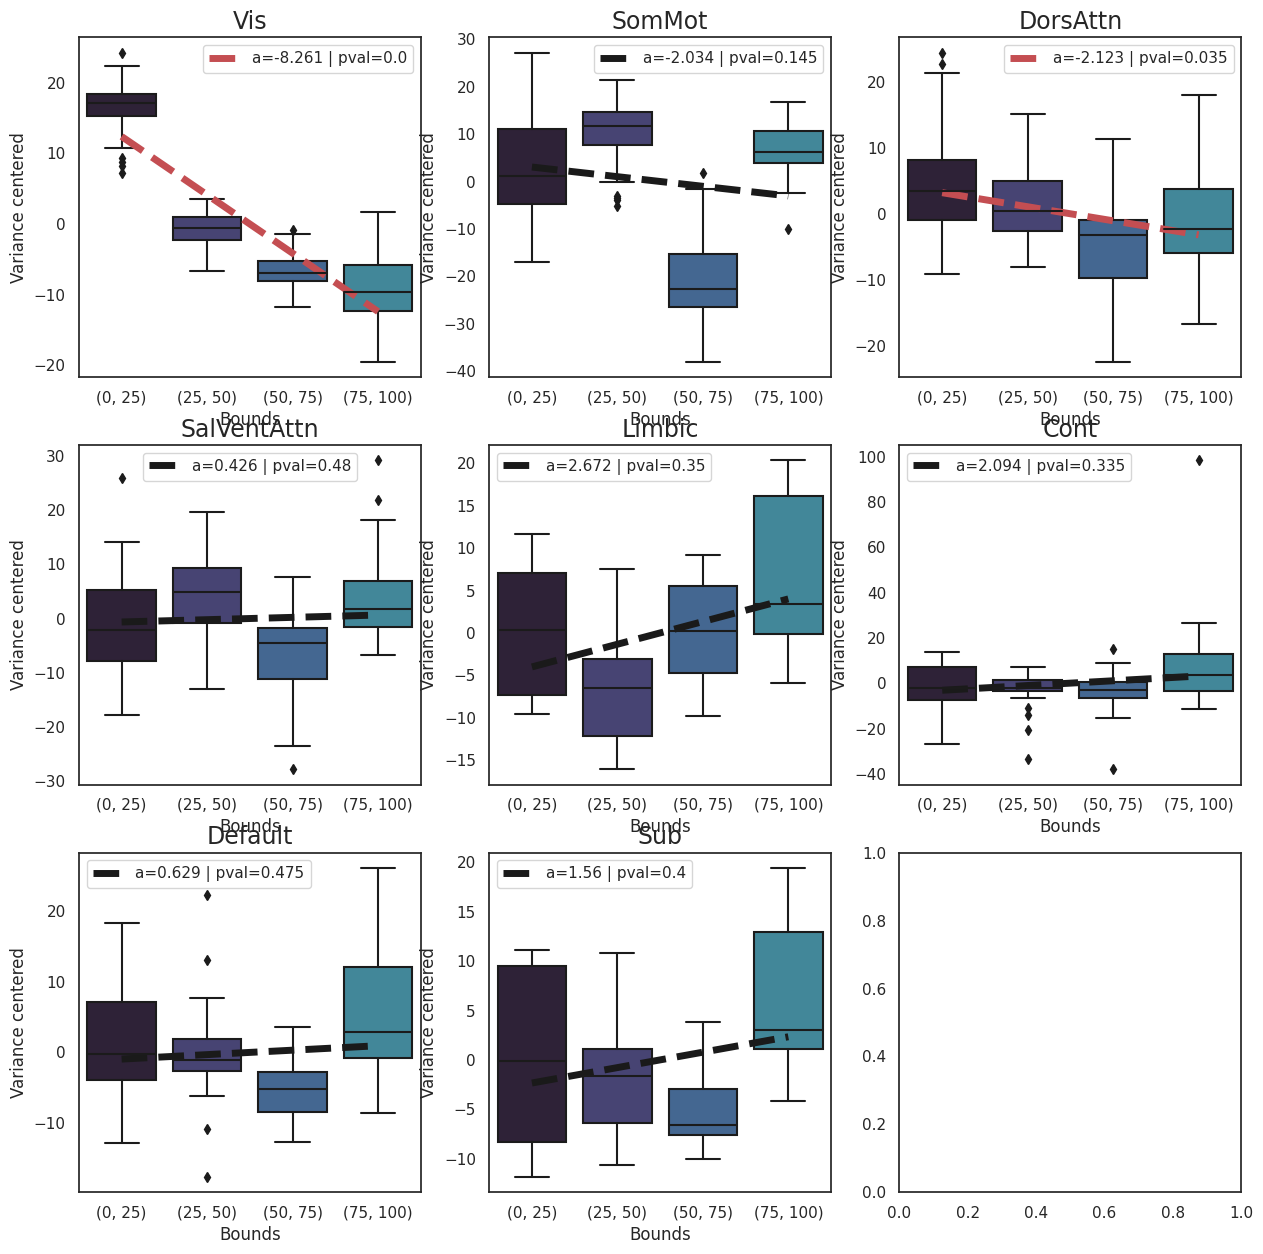

In [41]:
orig_df, null_df = fa_stats[1]
nscores, linear_coef = fa_null[1]

plot_standarddeviations(orig_df, null_df, nscores, linear_coef)

#### 3. Power

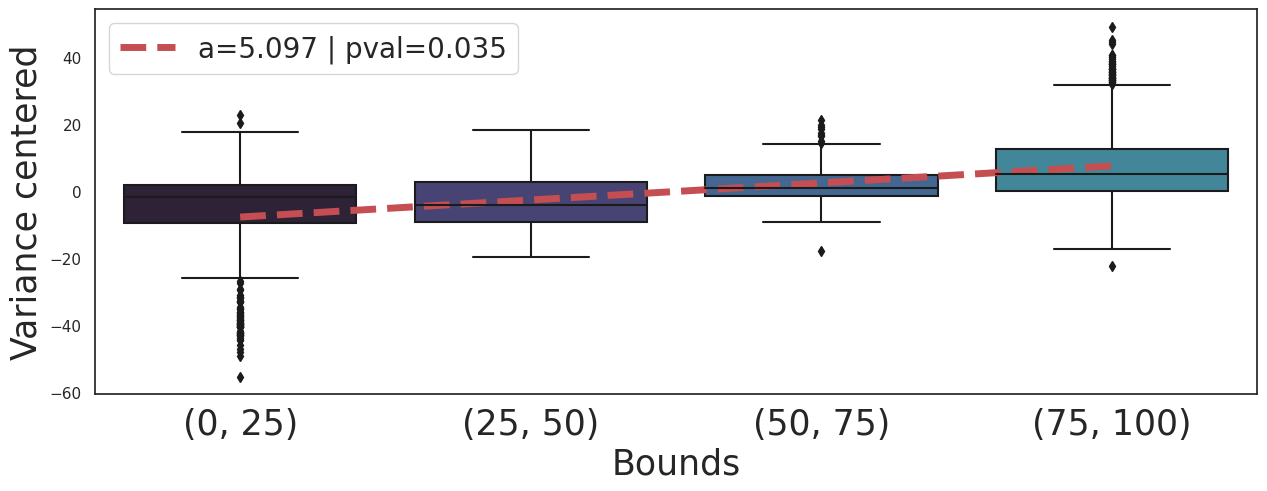

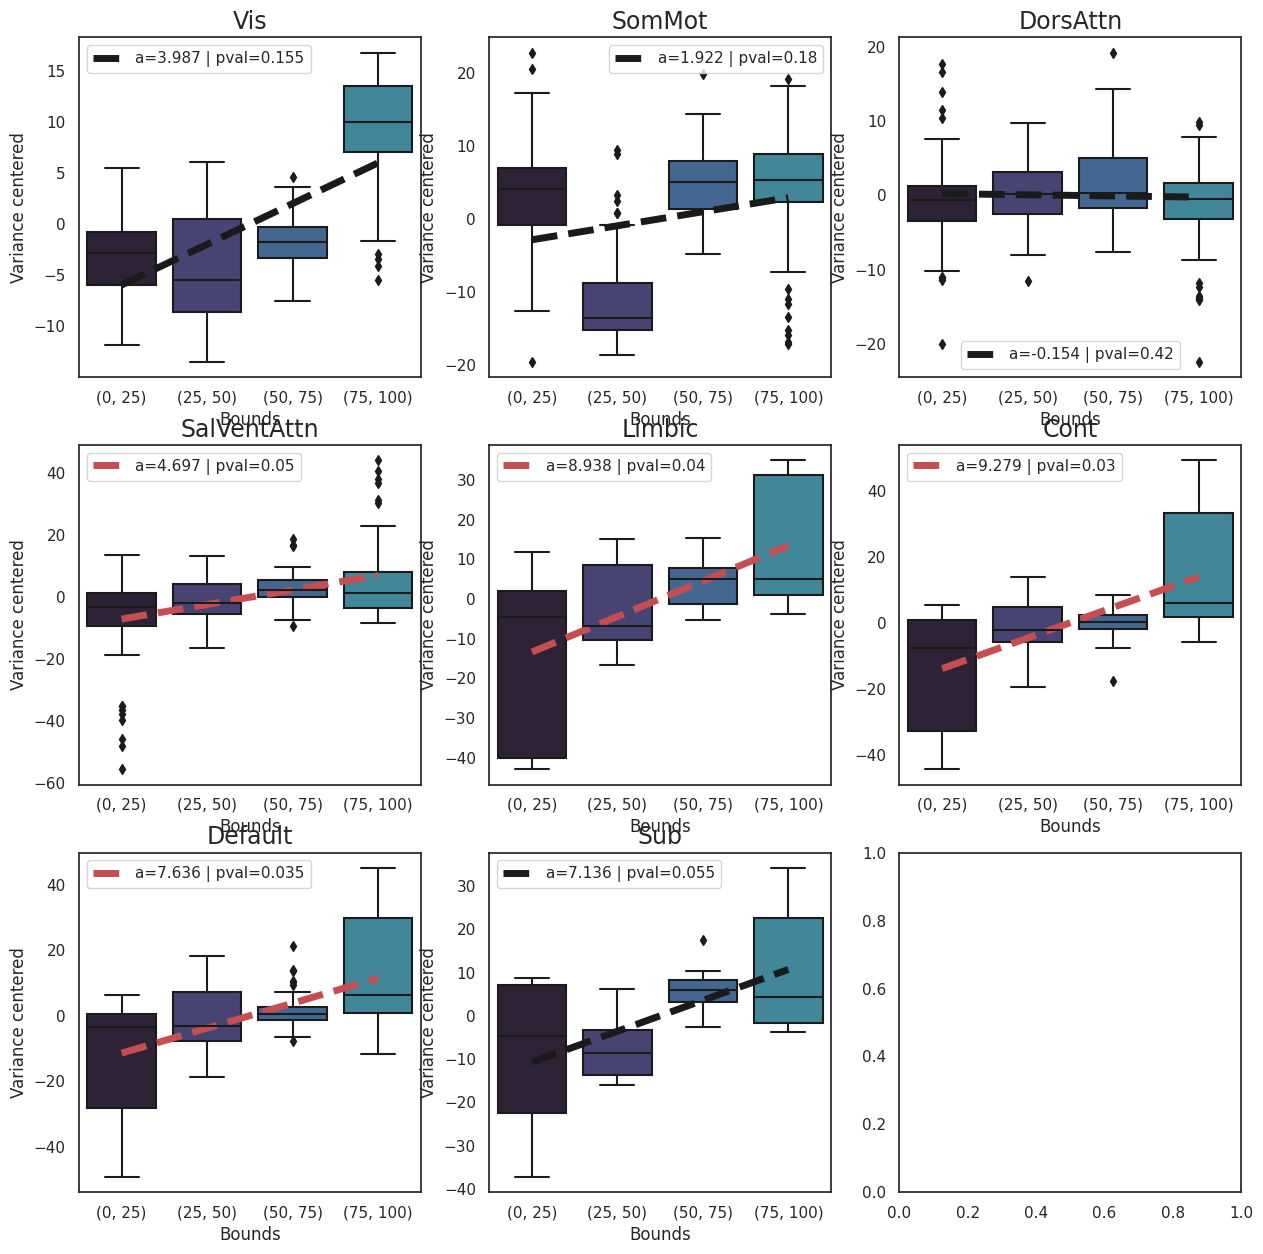

In [42]:
orig_df, null_df = fa_stats[2]
nscores, linear_coef = fa_null[2]

plot_standarddeviations(orig_df, null_df, nscores, linear_coef)